In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader,TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from utils.assimilate import run_assimilation
from models import cLSTM, cVAE

In [2]:
# this center aligns all figures

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Load Data:

In [3]:
# load background dataset for VAE
background_path = 'data/Ferguson_fire_background.npy'
background_data = np.array(np.load(open(background_path,'rb')))
cvae_background_dataset = torch.Tensor(background_data)

# load background dataset for LSTM (i.e. window size 3)
background_data = background_data.reshape(1, background_data.shape[0], 1, background_data.shape[1], background_data.shape[2])
x = np.array([background_data[:,0:3,:,:,:], background_data[:,1:4,:,:,:]])
clstm_background_dataset = torch.Tensor(x)

# load observation dataset
obs_path = 'data/Ferguson_fire_obs.npy'
obs_dataset = torch.Tensor(np.load(open(obs_path,'rb')))

### Load Pre-trained Models:

In [4]:
device = 'cpu'

# load LSTM
clstm = cLSTM.ConvLSTM(input_dim=1, hidden_dim=16, kernel_size=(3, 3), num_layers=2, batch_first=True, return_all_layers=False).to(device)
clstm.load_state_dict(torch.load('models/weights/clstm.pt', map_location=torch.device('cpu')))
clstm.eval()

# load VAE
cvae = cVAE.VAE_Conv(device).to(device)
cvae.load_state_dict(torch.load('models/weights/cvae.pt'))
cvae.eval();

### Generate Model Predictions:

The ConvLSTM model has been trained with a window size of 3 and a temporal resolution of 10. Consequently, we can only generate 2 forecasts that can be assimilated with the final 2 observation images.

In [5]:
clstm_preds = []
for image in torch.Tensor(clstm_background_dataset):
    _, pred = clstm(image)
    clstm_preds.append(pred.detach().numpy().squeeze())
clstm_preds = np.array(clstm_preds)

The ConvVAE model, however, has been trained with a temporal resolution of 1. Therefore, to generate predictions that can be assimilated with the final 4 observation images, we recurrently predict +10 consecutive timesteps from each of the background images.

In [6]:
timesteps = 10
cvae_preds = []
for i in range(len(cvae_background_dataset)-1):
    pred,_ = cvae(cvae_background_dataset[i].unsqueeze(0))
    for j in range(timesteps):
        if j == 0:
            pred,_ = cvae(cvae_background_dataset[i].unsqueeze(0)) 
        else:
            pred, _ = cvae(pred)           
    cvae_preds.append(pred.detach().numpy())
cvae_preds = np.array(cvae_preds).squeeze() 

### Compress predictions and observed data:

The predicted and observed images are both compressed using PCA. 

In [7]:
pca = PCA(n_components = 2)

# compress observations
obs_data_1D = np.reshape(obs_dataset,(obs_dataset.shape[0],obs_dataset.shape[1]*obs_dataset.shape[2]))
obs_data_compr = pca.fit_transform(obs_data_1D)

# compress LSTM predictions
clstm_preds_1D = np.reshape(clstm_preds,(clstm_preds.shape[0],clstm_preds.shape[1]*clstm_preds.shape[2]))
clstm_preds_compr = pca.transform(clstm_preds_1D)

# compress VAE predictions
cvae_preds_1D = np.reshape(cvae_preds,(cvae_preds.shape[0],cvae_preds.shape[1]*cvae_preds.shape[2]))
cvae_preds_compr = pca.transform(cvae_preds_1D)

### Perform data assimilation (DA):

Here, the `run_assimilation` function is assimilating the compressed model predictions with the compressed observations in the latent space.

In [8]:
# perform assimilation with LSTM predictions

clstm_assimilated_preds = run_assimilation(clstm_preds_compr, obs_data_compr)
clstm_assimilated_preds = np.array(pca.inverse_transform(clstm_assimilated_preds))

In [9]:
# perform assimilation with VAE predictions

cvae_assimilated_preds = run_assimilation(cvae_preds_compr, obs_data_compr)
cvae_assimilated_preds = np.array(pca.inverse_transform(cvae_assimilated_preds))

### MSE, before vs after DA:

Below is the MSE comparison between the model predictions and observations in the physical space, both before and after the assimilation process.

In [10]:
lstm_before = mean_squared_error(obs_data_1D[-2:], clstm_preds_1D)
lstm_after = mean_squared_error(obs_data_1D[-2:], clstm_assimilated_preds)

print(f'CLSTM MSE (in physical space) before DA: {lstm_before:.3f}')
print(f'CLSTM MSE (in physical space) after DA: {lstm_after:.3f}')

CLSTM MSE (in physical space) before DA: 0.181
CLSTM MSE (in physical space) after DA: 0.009


In [11]:
vae_before = mean_squared_error(obs_data_1D[1:], cvae_preds_1D)
vae_after = mean_squared_error(obs_data_1D[1:], cvae_assimilated_preds)

print(f'CVAE MSE (in physical space) before DA: {vae_before:.3f}')
print(f'CVAE MSE (in physical space) after DA: {vae_after:.3f}')

CVAE MSE (in physical space) before DA: 0.075
CVAE MSE (in physical space) after DA: 0.013


### Plot results (actual vs forecasted vs assimilated forecasted):

### Objective 1 Model (ConvLSTM):

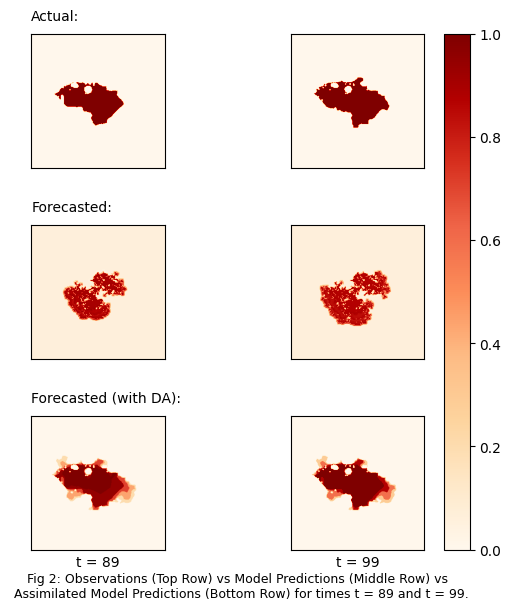

In [12]:
fig, ax = plt.subplots(3, 2, figsize=[6, 6])
fig.tight_layout(pad=2)
clstm_assimilated_preds = np.reshape(clstm_assimilated_preds, (clstm_assimilated_preds.shape[0], obs_dataset.shape[1], obs_dataset.shape[2]))
for n in range(len(clstm_background_dataset)):
    ax[0, n].imshow(obs_dataset[n+1], cmap='OrRd')
    ax[0, n].set_xticks([])
    ax[0, n].set_yticks([])
    ax[1, n].imshow(clstm_preds[n], cmap='OrRd')
    ax[1, n].set_xticks([])
    ax[1, n].set_yticks([])
    im = ax[2, n].imshow(clstm_assimilated_preds[n], cmap='OrRd')
    ax[2, n].set_xlabel(f't = {n*10+89}', fontsize=10)    
    ax[2, n].set_xticks([])
    ax[2, n].set_yticks([]) 
    if n==0:
        ax[0,n].set_title('Actual:', fontsize=10, pad=10, loc='left')
        ax[1,n].set_title('Forecasted:', fontsize=10, pad=10, loc='left')
        ax[2,n].set_title('Forecasted (with DA):', fontsize=10, pad=10, loc='left')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.054, pad=0.04)
cbar.mappable.set_clim(vmin=0, vmax=1)
txt="Fig 2: Observations (Top Row) vs Model Predictions (Middle Row) vs \n Assimilated Model Predictions (Bottom Row) for times t = 89 and t = 99."
plt.figtext(0.55, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=9);

### Objective 2 Model (ConvVAE):

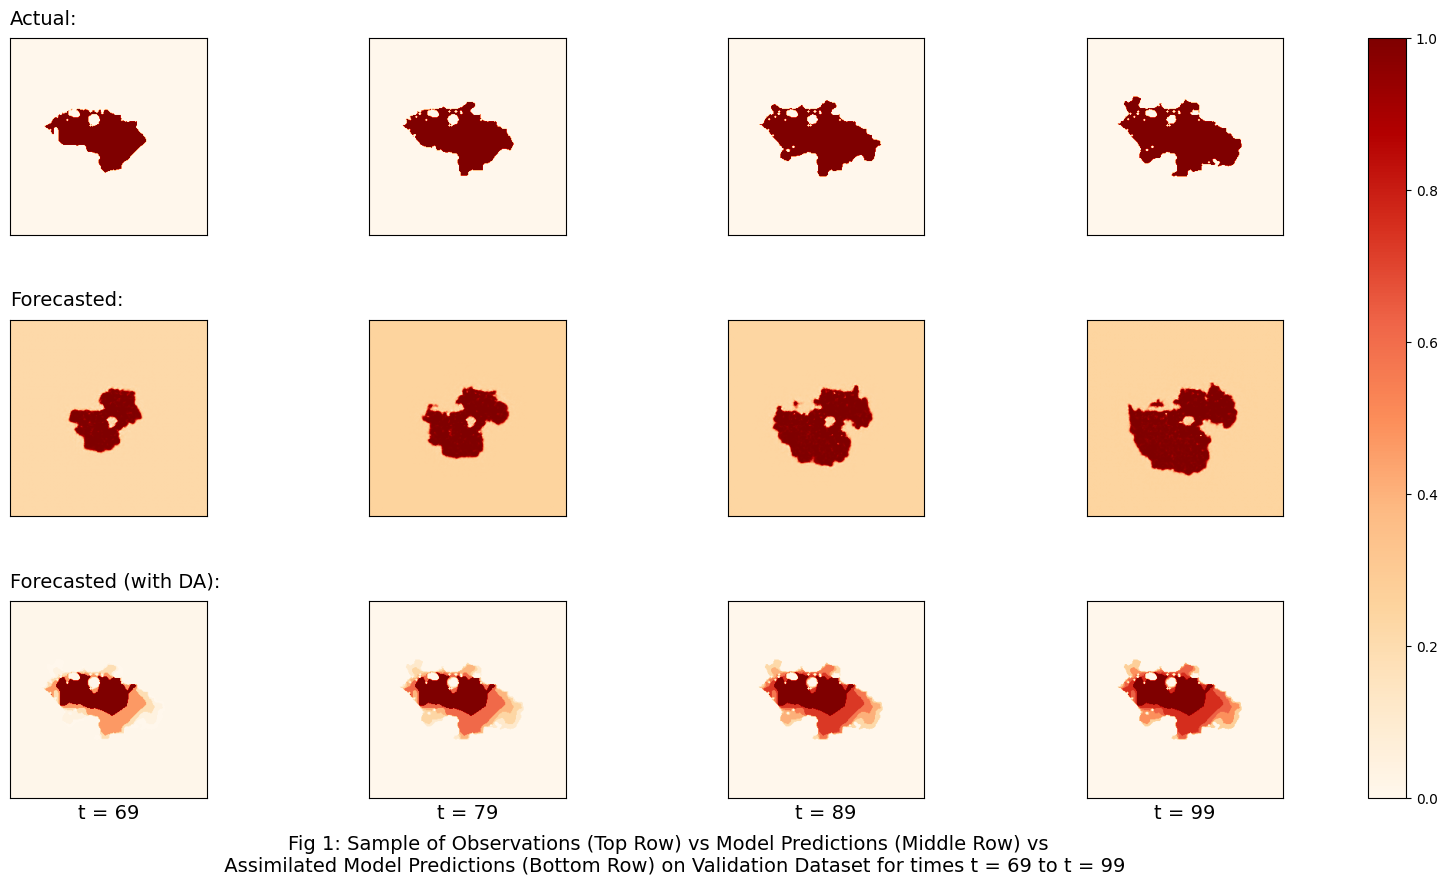

In [13]:
fig, ax = plt.subplots(3, 4, figsize=[18.5, 9])
fig.tight_layout(pad=4)
cvae_assimilated_preds = np.reshape(cvae_assimilated_preds, (cvae_assimilated_preds.shape[0], obs_dataset.shape[1], obs_dataset.shape[2]))
for n in range(len(cvae_background_dataset)-1):
    ax[0, n].imshow(obs_dataset[n+1], cmap='OrRd')
    ax[0, n].set_xticks([])
    ax[0, n].set_yticks([])
    ax[1, n].imshow(cvae_preds[n], cmap='OrRd')
    ax[1, n].set_xticks([])
    ax[1, n].set_yticks([])
    im = ax[2, n].imshow(cvae_assimilated_preds[n], cmap='OrRd')
    ax[2, n].set_xlabel(f't = {n*10+69}', fontsize=14)
    ax[2, n].set_xticks([])
    ax[2, n].set_yticks([])  
    if n==0:
        ax[0,n].set_title('Actual:', fontsize=14, pad=10, loc='left')
        ax[1,n].set_title('Forecasted:', fontsize=14, pad=10, loc='left')
        ax[2,n].set_title('Forecasted (with DA):', fontsize=14, pad=10, loc='left')
cbar = fig.colorbar(im, ax=ax.ravel().tolist());
cbar.mappable.set_clim(vmin=0,vmax=1)
txt="Fig 1: Sample of Observations (Top Row) vs Model Predictions (Middle Row) vs \n Assimilated Model Predictions (Bottom Row) for times t = 69 to t = 99"
plt.figtext(0.45, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14);